<a href="https://colab.research.google.com/github/redfear08/bot_trade_ml/blob/main/trading_bot_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install dependencies
!pip install pandas numpy scikit-learn tensorflow keras-tuner matplotlib kiteconnect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 771.5/771.5 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.8/247.8 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 10.0 MB/s eta 0:00:00


In [26]:
from kiteconnect import KiteConnect

kite = KiteConnect(api_key="klz728yv89qrljzs")
kite.set_access_token("4vhxunujbp17i8da0y1tiy7ayde4h5o8")

# Download the instruments list
instruments = kite.instruments()
import pandas as pd
instruments_df = pd.DataFrame(instruments)

# Save to a CSV file
instruments_df.to_csv("instruments.csv", index=False)

In [27]:
# Load the CSV file
instruments_df = pd.read_csv("instruments.csv")

# Find the instrument token for INFY
TOKEN_instrument = instruments_df[instruments_df.tradingsymbol == 'ONGC']
print(TOKEN_instrument)


       instrument_token  exchange_token tradingsymbol  \
10155         128079876          500312          ONGC   
78506            633601            2475          ONGC   

                                 name  last_price expiry  strike  tick_size  \
10155  OIL AND NATURAL GAS CORPORATIO         0.0    NaN     0.0       0.05   
78506       OIL AND NATURAL GAS CORP.         0.0    NaN     0.0       0.05   

       lot_size instrument_type segment exchange  
10155         1              EQ     BSE      BSE  
78506         1              EQ     NSE      NSE  


In [3]:
import pandas as pd
from kiteconnect import KiteConnect
import datetime as dt
import time
import numpy as np
import os

# Authentication and data fetching
api_key = 'klz728yv89qrljzs'
api_secret = '4vhxunujbp17i8da0y1tiy7ayde4h5o8'
kite = KiteConnect(api_key=api_key)
print("Login URL:", kite.login_url())
request_token = input("Enter request token: ")
data = kite.generate_session(request_token, api_secret=api_secret)
access_token = data["access_token"]
kite.set_access_token(access_token)

# Fetch historical data
def fetch_historical_data(kite, instrument_token, start_date, end_date, interval, csv_filename):
    delta = dt.timedelta(days=60)
    current_date = start_date
    all_data = []

    while current_date < end_date:
        to_date = min(current_date + delta, end_date)
        data = kite.historical_data(instrument_token, current_date, to_date, interval)
        all_data.extend(data)
        current_date = to_date + dt.timedelta(days=1)
        time.sleep(1)  # Avoid hitting API rate limits

    df = pd.DataFrame(all_data)
    df.to_csv(csv_filename, mode='w', index=False, header=True)
    return df

# Fetch historical data
instrument_token = '633601' #NIFTY 50
start_date = dt.datetime(2016, 1, 1)
end_date = dt.datetime(2023, 12, 31)
interval = 'minute'
csv_filename = 'historical_data.csv'


fetch_historical_data(kite, instrument_token, start_date, end_date, interval, csv_filename)



Login URL: https://kite.zerodha.com/connect/login?api_key=klz728yv89qrljzs&v=3
Enter request token: IYmUhfP1ZJW0ErjBrB22xjwSP6NNM2SM


,date,open,high,low,close,volume
0,2016-01-04 09:15:00+05:30,154.65,155.50,153.90,154.75,21660
1,2016-01-04 09:16:00+05:30,154.60,155.10,154.60,155.10,14957
2,2016-01-04 09:17:00+05:30,155.10,155.15,154.60,154.80,8162
3,2016-01-04 09:18:00+05:30,154.90,154.95,154.45,154.55,17469
4,2016-01-04 09:19:00+05:30,154.55,154.55,154.30,154.40,6998
...,...,...,...,...,...,...
727728,2023-12-29 15:25:00+05:30,205.05,205.20,204.90,205.20,135352
727729,2023-12-29 15:26:00+05:30,205.15,205.25,205.00,205.15,122354
727730,2023-12-29 15:27:00+05:30,205.20,205.45,205.15,205.45,135351
727731,2023-12-29 15:28:00+05:30,205.35,205.65,205.20,205.40,246462


Data fetched:
                        date    open    high     low   close  volume
0  2016-01-04 09:15:00+05:30  154.65  155.50  153.90  154.75   21660
1  2016-01-04 09:16:00+05:30  154.60  155.10  154.60  155.10   14957
2  2016-01-04 09:17:00+05:30  155.10  155.15  154.60  154.80    8162
3  2016-01-04 09:18:00+05:30  154.90  154.95  154.45  154.55   17469
4  2016-01-04 09:19:00+05:30  154.55  154.55  154.30  154.40    6998
DataFrame with features:
                            open    high    low  close  volume   SMA_50  \
date                                                                      
2016-01-04 12:34:00+05:30  155.7  155.70  155.5  155.5    2235  155.306   
2016-01-04 12:35:00+05:30  155.5  155.50  155.4  155.4     902  155.314   
2016-01-04 12:36:00+05:30  155.4  155.70  155.4  155.6    1055  155.328   
2016-01-04 12:37:00+05:30  155.6  155.75  155.6  155.7    5288  155.344   
2016-01-04 12:38:00+05:30  155.7  155.75  155.6  155.6    1973  155.361   

                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8184/8184 [==============================] - 33s 4ms/step - loss: 0.6539 - accuracy: 0.6267 - val_loss: 0.6458 - val_accuracy: 0.6348
Epoch 3/200
8184/8184 [==============================] - 34s 4ms/step - loss: 0.6494 - accuracy: 0.6302 - val_loss: 0.6455 - val_accuracy: 0.6348
Epoch 4/200
8184/8184 [==============================] - 32s 4ms/step - loss: 0.6473 - accuracy: 0.6321 - val_loss: 0.6450 - val_accuracy: 0.6357
Epoch 5/200
8184/8184 [==============================] - 32s 4ms/step - loss: 0.6468 - accuracy: 0.6326 - val_loss: 0.6445 - val_accuracy: 0.6362
Epoch 6/200
8184/8184 [==============================] - 34s 4ms/step - loss: 0.6462 - accuracy: 0.6330 - val_loss: 0.6444 - val_accuracy: 0.6365
Epoch 7/200
8184/8184 [==============================] - 32s 4ms/step - loss: 0.6458 - accuracy: 0.6329 - val_loss: 0.6445 - val_accuracy: 0.6372
Epoch 8/200
8184/8184 [==============================] - 33s 4ms/step - loss: 0.6456 - accuracy: 0.6334 - val_loss: 0.6445 - val_accurac

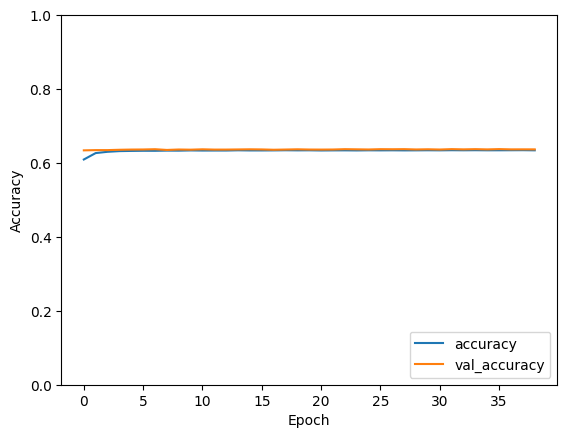

In [5]:
# Google Colab Script: Neural Network Model Training with Additional Features

# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_tuner as kt
import matplotlib.pyplot as plt
import os

model_path = 'best_nn_model.h5'

# Read the DataFrame from a CSV file
csv_filename = 'historical_data.csv'  # Update with your CSV file path
df = pd.read_csv(csv_filename)
print("Data fetched:")
print(df.head())

# Feature Engineering
def add_features(df):
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df['SMA_50'] = df['close'].rolling(window=50).mean()
    df['SMA_200'] = df['close'].rolling(window=200).mean()
    df['RSI'] = calculate_rsi(df, 14)
    df['Bollinger_Upper'], df['Bollinger_Lower'] = calculate_bollinger_bands(df, 20)
    df['MACD'], df['MACD_Signal'] = calculate_macd(df)
    df['Stochastic_%K'], df['Stochastic_%D'] = calculate_stochastic_oscillator(df, 14)
    df['Momentum'] = df['close'] / df['close'].shift(10) - 1
    df['VWAP'] = calculate_vwap(df)
    df['ATR'] = calculate_atr(df)
    df['Target'] = np.where(df['close'].shift(-1) > df['close'], 1, 0)
    df = df.dropna()
    return df

def calculate_rsi(df, window=14):
    delta = df['close'].diff(1)
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def calculate_bollinger_bands(df, window=20):
    sma = df['close'].rolling(window=window).mean()
    std = df['close'].rolling(window=window).std()
    upper_band = sma + (std * 2)
    lower_band = sma - (std * 2)
    return upper_band, lower_band

def calculate_macd(df, short_window=12, long_window=26, signal_window=9):
    ema_12 = df['close'].ewm(span=short_window, adjust=False).mean()
    ema_26 = df['close'].ewm(span=long_window, adjust=False).mean()
    macd = ema_12 - ema_26
    signal_line = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal_line

def calculate_stochastic_oscillator(df, window=14):
    l14 = df['low'].rolling(window=window).min()
    h14 = df['high'].rolling(window=window).max()
    k = (df['close'] - l14) * 100 / (h14 - l14)
    d = k.rolling(window=3).mean()
    return k, d

def calculate_vwap(df):
    cum_tp_volume = (df['close'] * df['volume']).cumsum()
    cum_volume = df['volume'].cumsum()
    return cum_tp_volume / cum_volume

def calculate_atr(df, window=14):
    df['H-L'] = df['high'] - df['low']
    df['H-PC'] = np.abs(df['high'] - df['close'].shift(1))
    df['L-PC'] = np.abs(df['low'] - df['close'].shift(1))
    tr = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
    atr = tr.rolling(window=window).mean()
    return atr

# Add features to the DataFrame
df = add_features(df)
print("DataFrame with features:")
print(df.head())

if df.empty:
    print("The DataFrame after adding features is empty. Exiting.")
else:
    # Prepare the dataset
    X = df[['SMA_50', 'SMA_200', 'RSI', 'Bollinger_Upper', 'Bollinger_Lower', 'MACD', 'MACD_Signal', 'Stochastic_%K', 'Stochastic_%D', 'Momentum', 'VWAP']]
    y = df['Target']

    # Check the number of features
    print(f"Number of features: {X.shape[1]}")  # Should be 11

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print("Training set shape:", X_train.shape)
    print("Test set shape:", X_test.shape)

    if X_train.empty or X_test.empty:
        print("Training or test set is empty. Exiting.")
    else:
        # Data Preprocessing
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Hyperparameter Tuning Function
        def build_model(hp):
            model = Sequential()
            input_dim = X_train_scaled.shape[1]  # Ensure input_dim is correct
            model.add(Dense(units=hp.Int('units_input', min_value=32, max_value=512, step=32), activation='relu', input_dim=input_dim))
            model.add(Dropout(hp.Float('dropout_input', 0.0, 0.5, step=0.1)))
            model.add(BatchNormalization())

            for i in range(hp.Int('num_layers', 1, 3)):
                model.add(Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32), activation='relu'))
                model.add(Dropout(hp.Float('dropout_' + str(i), 0.0, 0.5, step=0.1)))
                model.add(BatchNormalization())

            model.add(Dense(1, activation='sigmoid'))

            model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                          loss='binary_crossentropy',
                          metrics=['accuracy'])
            return model

        # Hyperparameter Search
        tuner = kt.RandomSearch(build_model,
                                objective='val_accuracy',
                                max_trials=10,
                                executions_per_trial=1,
                                directory='my_dir',
                                project_name='intro_to_kt')

        tuner.search(X_train_scaled, y_train, epochs=10, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

        # Get the optimal hyperparameters
        best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

        # Build the model with the optimal hyperparameters
        nn_model = tuner.hypermodel.build(best_hps)

        # Continue training the model with early stopping and model checkpoint callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint(model_path, save_best_only=True, monitor='val_loss')

        history = nn_model.fit(X_train_scaled, y_train,
                               epochs=200,
                               batch_size=64,
                               validation_split=0.1,
                               callbacks=[early_stopping, model_checkpoint],
                               verbose=1)

        # Evaluate the model
        loss, accuracy = nn_model.evaluate(X_test_scaled, y_test)
        print(f"Neural Network Model Accuracy: {accuracy}")

        # Save Neural Network Model
        nn_model.save(model_path)

        # Plot training history
        plt.plot(history.history['accuracy'], label='accuracy')
        plt.plot(history.history['val_accuracy'], label='val_accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.ylim([0, 1])
        plt.legend(loc='lower right')
        plt.show()

